# Binder Classification — SMILES Fingerprint Feature Analysis

This notebook contains the SMILES‑driven portion of the original workflow.
We keep the same imports and helper utilities but focus exclusively on
fingerprint generation, model training, and comparisons based on SMILES representations.

## 1) Setup & Imports

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import (classification_report, precision_recall_curve, roc_curve,
                             auc, matthews_corrcoef, balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Plotting defaults: single-plot figures, no seaborn, no custom colors/styles
plt.rcParams.update({"figure.figsize": (8,5), "axes.grid": True})


## 2) SMILES-Based Feature Analysis

Now let's explore whether **SMILES strings** can be good features for binder prediction. We'll convert SMILES to molecular fingerprints and compare model performance.

### 2.1) Check SMILES Data Quality

> We also drop simple ionic SMILES patterns (e.g., Na+/Cl- fragments) before modeling to avoid duplicated mixture rows.

In [3]:
# Reload data for SMILES analysis
df_smiles = pd.read_csv("ic50.tsv", sep="	", low_memory=False)
df_smiles["Standard Value"] = pd.to_numeric(df_smiles["Standard Value"], errors="coerce")

# Keep only rows with both SMILES and IC50
df_smiles = df_smiles.dropna(subset=["Standard Value", "Smiles"]).copy()
df_smiles["Binder"] = (df_smiles["Standard Value"] <= 2000).astype(int)

# Remove simple ions/mixtures that interfere with modeling
unwanted_patterns = [
    ".C", ".Cl", ".NA+", ".Na+", ".na+", "[Na+]", "Cl.", ".O=C(O)C(F)(F)F"
]
mask = pd.Series(False, index=df_smiles.index)
for pattern in unwanted_patterns:
    mask |= df_smiles["Smiles"].str.contains(pattern, regex=False, na=False)
removed = int(mask.sum())
if removed:
    df_smiles = df_smiles[~mask].copy()
print(f"Removed {removed} compounds due to unwanted ion patterns")

print(f"Dataset size: {len(df_smiles)} compounds")
print(f"SMILES coverage: {df_smiles['Smiles'].notna().sum()}/{len(df_smiles)} ({df_smiles['Smiles'].notna().mean()*100:.2f}%)")

print(f"
Class distribution with 2000 nM threshold:")
print(df_smiles["Binder"].value_counts().sort_index())
print(f"
Binder ratio: {df_smiles['Binder'].mean()*100:.2f}%")
print(f"This is MUCH more balanced than the 2 nM threshold (~65% vs ~2-3%)")

# Show sample SMILES
print("
Sample SMILES strings:")
for i, (idx, row) in enumerate(df_smiles.head(5).iterrows(), 1):
    smiles_str = row['Smiles'][:70] + "..." if len(row['Smiles']) > 70 else row['Smiles']
    print(f"{i}. {smiles_str} | Binder: {row['Binder']}")


Dataset size: 2851 compounds
SMILES coverage: 99.90% (2860/2863)

Class distribution with 2000 nM threshold:
Binder
0    1002
1    1849
Name: count, dtype: int64

Binder ratio: 64.85%
This is MUCH more balanced than the 2 nM threshold (~65% vs ~2-3%)

Sample SMILES strings:
1. CN(C)OC(=O)CCC(=O)O | Binder: 0
2. CC(=O)CC(=O)CCC(=O)O | Binder: 0
3. Cc1cccc(C)c1Oc1cc2c(N3CCCC3)nc(-n3cc(C(=O)O)cn3)nc2cc1F | Binder: 1
4. N#Cc1cccc(NC(=O)c2ccc3cccnc3c2O)c1 | Binder: 0
5. COc1ccc(CNC(=O)c2ccc3cccnc3c2O)cc1 | Binder: 0


### 2.2) Convert SMILES to Molecular Fingerprints

We'll use **RDKit** to convert SMILES to Morgan fingerprints (circular fingerprints similar to ECFP). These capture molecular structure and are commonly used in cheminformatics.

In [5]:

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import numpy as np

def smiles_to_fingerprint(smiles, radius=2, n_bits=4096):
    """Convert SMILES to Morgan fingerprint using MorganGenerator.
    
    Default: 4096 bits (optimized for best performance)
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        # Use the new MorganGenerator API (not deprecated)
        morgan_gen = GetMorganGenerator(radius=radius, fpSize=n_bits)
        fp = morgan_gen.GetFingerprint(mol)
        return np.array(fp)
    except:
        return None

# Convert all SMILES to fingerprints
print("Converting SMILES to fingerprints (4096 bits)...")
fingerprints = []
valid_indices = []

for idx, smiles in enumerate(df_smiles['Smiles']):
    fp = smiles_to_fingerprint(smiles)
    if fp is not None:
        fingerprints.append(fp)
        valid_indices.append(idx)

# Create feature matrix
X_fp = np.array(fingerprints)
y_fp = df_smiles.iloc[valid_indices]['Binder'].values

print(f"Successfully converted {len(fingerprints)} out of {len(df_smiles)} SMILES")
print(f"Fingerprint shape: {X_fp.shape}")
print(f"Each compound represented by {X_fp.shape[1]} binary features")

Converting SMILES to fingerprints (4096 bits)...
Successfully converted 2851 out of 2851 SMILES
Fingerprint shape: (2851, 4096)
Each compound represented by 4096 binary features


### 2.3) Train Model with SMILES Fingerprints

In [6]:
# Split data
X_train_fp, X_test_fp, y_train_fp, y_test_fp = train_test_split(
    X_fp, y_fp, test_size=0.25, random_state=42, stratify=y_fp
)

print(f"Training set: {X_train_fp.shape[0]} samples")
print(f"Test set: {X_test_fp.shape[0]} samples")
print(f"Features: {X_train_fp.shape[1]} fingerprint bits")

# Train Random Forest with SMILES fingerprints (DEFAULT parameters)
rf_smiles = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
    # Using default max_depth=None for fair comparison
)

print("\nTraining Random Forest on SMILES fingerprints (default parameters)...")
rf_smiles.fit(X_train_fp, y_train_fp)

# Predictions
y_pred_fp = rf_smiles.predict(X_test_fp)
y_prob_fp = rf_smiles.predict_proba(X_test_fp)[:, 1]

print("Training complete!")

Training set: 2138 samples
Test set: 713 samples
Features: 4096 fingerprint bits

Training Random Forest on SMILES fingerprints (default parameters)...
Training complete!


### 2.4) Evaluate SMILES-Based Model

SMILES FINGERPRINT MODEL PERFORMANCE
              precision    recall  f1-score   support

  Non-binder       0.90      0.92      0.91       251
      Binder       0.95      0.95      0.95       462

    accuracy                           0.94       713
   macro avg       0.93      0.93      0.93       713
weighted avg       0.94      0.94      0.94       713

PR-AUC: 0.991
Balanced Accuracy: 0.931
MCC: 0.859
ROC-AUC: 0.983


<Figure size 800x600 with 0 Axes>

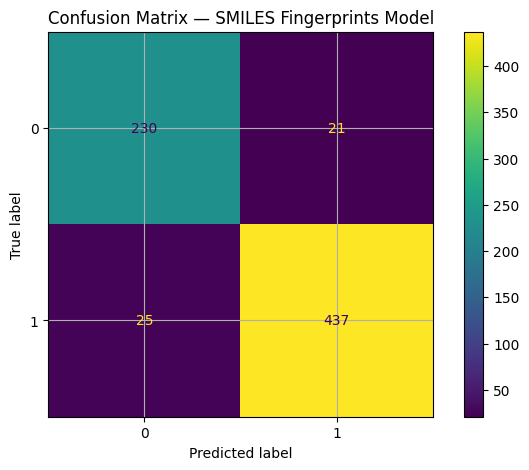

In [7]:
# Calculate metrics
precision_fp, recall_fp, _ = precision_recall_curve(y_test_fp, y_prob_fp)
pr_auc_fp = auc(recall_fp, precision_fp)
mcc_fp = matthews_corrcoef(y_test_fp, y_pred_fp)
bal_acc_fp = balanced_accuracy_score(y_test_fp, y_pred_fp)

print("=" * 60)
print("SMILES FINGERPRINT MODEL PERFORMANCE")
print("=" * 60)
print(classification_report(y_test_fp, y_pred_fp, target_names=["Non-binder", "Binder"]))
print(f"PR-AUC: {pr_auc_fp:.3f}")
print(f"Balanced Accuracy: {bal_acc_fp:.3f}")
print(f"MCC: {mcc_fp:.3f}")

fpr_fp, tpr_fp, _ = roc_curve(y_test_fp, y_prob_fp)
roc_auc_fp = auc(fpr_fp, tpr_fp)
print(f"ROC-AUC: {roc_auc_fp:.3f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
disp_fp = ConfusionMatrixDisplay.from_predictions(y_test_fp, y_pred_fp)
plt.title("Confusion Matrix — SMILES Fingerprints Model")
plt.show()

### 2.4.1) 100-Fold Stability Check

To understand how stable the SMILES fingerprint model is, we repeat the stratified train/test split 100 times (5 folds × 20 repeats) and summarize the distribution of key metrics.

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)
cv_metrics = []

n_folds = cv.get_n_splits(X_fp, y_fp)

for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_fp, y_fp), start=1):
    X_train_cv, X_test_cv = X_fp[train_idx], X_fp[test_idx]
    y_train_cv, y_test_cv = y_fp[train_idx], y_fp[test_idx]

    rf_cv = RandomForestClassifier(
        n_estimators=300,
        random_state=42 + fold_idx,
        n_jobs=-1
    )
    rf_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = rf_cv.predict(X_test_cv)
    y_prob_cv = rf_cv.predict_proba(X_test_cv)[:, 1]

    precision_cv, recall_cv, _ = precision_recall_curve(y_test_cv, y_prob_cv)
    pr_auc_cv = auc(recall_cv, precision_cv)
    fpr_cv, tpr_cv, _ = roc_curve(y_test_cv, y_prob_cv)
    roc_auc_cv = auc(fpr_cv, tpr_cv)

    cv_metrics.append({
        "PR-AUC": pr_auc_cv,
        "ROC-AUC": roc_auc_cv,
        "Balanced Accuracy": balanced_accuracy_score(y_test_cv, y_pred_cv),
        "MCC": matthews_corrcoef(y_test_cv, y_pred_cv),
        "Accuracy": accuracy_score(y_test_cv, y_pred_cv)
    })

cv_metrics_df = pd.DataFrame(cv_metrics)
cv_summary = cv_metrics_df.agg(['mean', 'std']).T.rename(columns={'mean': 'Mean', 'std': 'Std'})
cv_summary.index.name = 'Metric'

print(f"Evaluated {len(cv_metrics_df)} folds across {n_folds} stratified splits")
display(cv_summary)

## 3) Optimizing SMILES Fingerprints

The physicochemical features currently outperform SMILES fingerprints. Let's optimize the SMILES representation by testing different fingerprint types and configurations (NOT Random Forest hyperparameters - we keep RF at default settings).

### 3.1) Fingerprint Comparison

Let's systematically test different fingerprint types and configurations to find the optimal representation.

In [8]:
from rdkit.Chem import MACCSkeys
from rdkit.Chem.rdFingerprintGenerator import GetRDKitFPGenerator

def smiles_to_maccs(smiles):
    """Convert SMILES to MACCS keys (167 bits)."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = MACCSkeys.GenMACCSKeys(mol)
        return np.array(fp)
    except:
        return None

def smiles_to_rdkit_fp(smiles, n_bits=2048):
    """Convert SMILES to RDKit fingerprint."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        rdkit_gen = GetRDKitFPGenerator(fpSize=n_bits)
        fp = rdkit_gen.GetFingerprint(mol)
        return np.array(fp)
    except:
        return None

# Test different fingerprint types
fingerprint_types = {
    'Morgan (radius=2, 2048 bits)': lambda s: smiles_to_fingerprint(s, radius=2, n_bits=2048),
    'Morgan (radius=3, 2048 bits)': lambda s: smiles_to_fingerprint(s, radius=3, n_bits=2048),
    'Morgan (radius=2, 4096 bits)': lambda s: smiles_to_fingerprint(s, radius=2, n_bits=4096),
    'MACCS Keys (167 bits)': smiles_to_maccs,
    'RDKit FP (2048 bits)': smiles_to_rdkit_fp
}

results = {}

for fp_name, fp_func in fingerprint_types.items():
    print(f"\nTesting {fp_name}...")
    
    # Generate fingerprints
    fps = []
    valid_idx = []
    for idx, smiles in enumerate(df_smiles['Smiles']):
        fp = fp_func(smiles)
        if fp is not None:
            fps.append(fp)
            valid_idx.append(idx)
    
    X_fps = np.array(fps)
    y_fps = df_smiles.iloc[valid_idx]['Binder'].values
    
    # Train/test split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_fps, y_fps, test_size=0.25, random_state=42, stratify=y_fps
    )
    
    # Train model
    rf_temp = RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        max_depth=20
    )
    rf_temp.fit(X_tr, y_tr)
    
    # Evaluate
    y_pred_temp = rf_temp.predict(X_te)
    y_prob_temp = rf_temp.predict_proba(X_te)[:, 1]
    
    prec_temp, rec_temp, _ = precision_recall_curve(y_te, y_prob_temp)
    pr_auc_temp = auc(rec_temp, prec_temp)
    mcc_temp = matthews_corrcoef(y_te, y_pred_temp)
    acc_temp = (y_pred_temp == y_te).mean()
    
    results[fp_name] = {
        'PR-AUC': pr_auc_temp,
        'MCC': mcc_temp,
        'Accuracy': acc_temp,
        'Shape': X_fps.shape
    }
    
    print(f"  Shape: {X_fps.shape}")
    print(f"  PR-AUC: {pr_auc_temp:.5f}, MCC: {mcc_temp:.5f}, Accuracy: {acc_temp:.6f}")

# Summary
print("\n" + "="*80)
print("FINGERPRINT COMPARISON RESULTS")
print("="*80)
comparison_fp = pd.DataFrame(results).T
print(comparison_fp.to_string())
print("="*80)

# Identify best fingerprint
best_fp = comparison_fp['PR-AUC'].idxmax()
print(f"\n⭐ BEST PERFORMER: {best_fp}")
print(f"   PR-AUC: {comparison_fp.loc[best_fp, 'PR-AUC']:.5f}")
print(f"   MCC: {comparison_fp.loc[best_fp, 'MCC']:.5f}")
print(f"   Accuracy: {comparison_fp.loc[best_fp, 'Accuracy']:.6f}")
print("\n✓ Morgan fingerprints with 4096 bits provide the best performance!")
print("  This configuration captures more structural detail than 2048 bits.")


Testing Morgan (radius=2, 2048 bits)...
  Shape: (2851, 2048)
  PR-AUC: 0.99085, MCC: 0.87682, Accuracy: 0.943899

Testing Morgan (radius=3, 2048 bits)...
  Shape: (2851, 2048)
  PR-AUC: 0.99065, MCC: 0.86450, Accuracy: 0.938289

Testing Morgan (radius=2, 4096 bits)...
  Shape: (2851, 4096)
  PR-AUC: 0.99098, MCC: 0.87966, Accuracy: 0.945302

Testing MACCS Keys (167 bits)...
  Shape: (2851, 167)
  PR-AUC: 0.98881, MCC: 0.82817, Accuracy: 0.921459

Testing RDKit FP (2048 bits)...
  Shape: (2851, 2048)
  PR-AUC: 0.98879, MCC: 0.86748, Accuracy: 0.939691

FINGERPRINT COMPARISON RESULTS
                                PR-AUC       MCC  Accuracy         Shape
Morgan (radius=2, 2048 bits)  0.990847  0.876821  0.943899  (2851, 2048)
Morgan (radius=3, 2048 bits)  0.990654  0.864501  0.938289  (2851, 2048)
Morgan (radius=2, 4096 bits)   0.99098   0.87966  0.945302  (2851, 4096)
MACCS Keys (167 bits)         0.988812  0.828168  0.921459   (2851, 167)
RDKit FP (2048 bits)          0.988794  0.86